# 폐렴 진단하기
대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았는데, 성능을 높여서 숙련된 의사분들과 비슷한 90%이상에 도달하는 성능개선시킨 폐렴진단기 만들어보기

## tf.data파이프라인
: 이미지 데이터 세트를 위한 효율적인 TensolFlow 입력 파이프 라인 구축
순서
1. 샘플데이터 다운로드
2. 라벨 데이터 파일 열기
3. Dataset.from_tensor_slices() 방법으로 파일 목록 데이터 세트 열기
4. filelist_ds 샘플을 가져와서 생성되었는지 왁인
5. map()방법으로 (이미지, 레이블) 쌍을 반환
6. label로 변환한 일부샘플 관찰
7. 배치크기 결정
8. CNN 모델만들기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### DATA LOAD

In [127]:
#앞으로 필요한 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/AIFFEL_PROJECT/EXPLORATION_11')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_11


In [128]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### DATA VALIDATION

In [129]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [130]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 파일 경로에 폐렴인지 아닌지 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_11/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_11/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [131]:
filenames[0]  #PNEUMON

'/aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_11/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg'

In [132]:
filenames[250]  #NORMAL

'/aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_11/chest_xray/data/train/NORMAL/IM-0668-0001.jpeg'

In [133]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [134]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [135]:
#train_list_ds/val_list_ds 샘플을 가져와서 예상대로 생성되었는지 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### Data preprocessing

In [136]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
#NORMAL/PNEUNOMIA 라벨데이터 만들기

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) #OS별 파일 경로 나는 문자
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [137]:
get_label('/aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_11/chest_xray/data/train/PNEUMONIA/person466_bacteria_1984.jpeg')

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [138]:
get_label('/aiffel/aiffel/AIFFEL_PROJECT/EXPLORATION_11/chest_xray/data/train/NORMAL/NORMAL2-IM-1084-0001.jpeg')

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [139]:
# 이미지를 알맞은 형식으로 바꿉니다.
#이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [140]:
#train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [141]:
for image, label in train_ds.take(7):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False


In [142]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [143]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

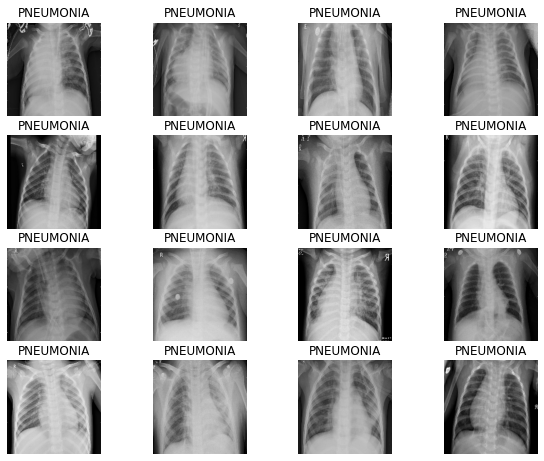

In [144]:
# 데이터 시각화
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 성능개선
### 1. CNN 모델링
1) Dropout 정규화 기법 사용                                                                        
2) Batch Normalization 정규화 기법 사용                                                        
3) Dropout 비율 변경

### Model 생성

In [93]:
# 1. Dropout 정규화 기법만 사용
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [94]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [95]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [96]:
#데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Model 학습

In [97]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [98]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 41s 132ms/step - loss: 0.5261 - accuracy: 0.7112 - precision: 0.8522 - recall: 0.7417 - val_loss: 0.8898 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 129ms/step - loss: 0.2590 - accuracy: 0.9003 - precision: 0.9759 - recall: 0.8877 - val_loss: 2.4886 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 129ms/step - loss: 0.2024 - accuracy: 0.9289 - precision: 0.9787 - recall: 0.9244 - val_loss: 0.4072 - val_accuracy: 0.9385 - val_precision: 0.9835 - val_recall: 0.9321
Epoch 4/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1994 - accuracy: 0.9233 - precision: 0.9804 - recall: 0.9148 - val_loss: 0.2105 - val_accuracy: 0.9385 - val_precision: 0.9289 - val_recall: 0.9921
Epoch 5/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1631 - accura

### 평가

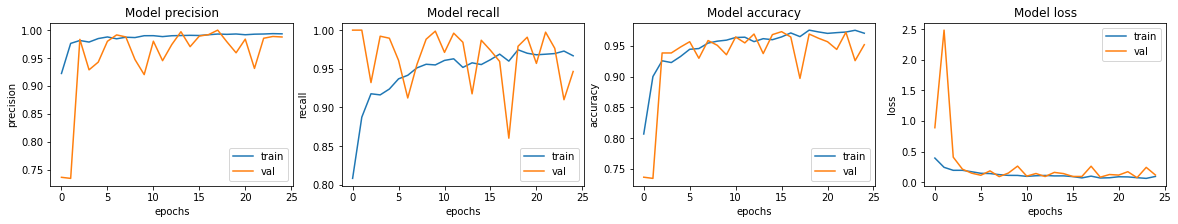

In [99]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [100]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 0.8845 - accuracy: 0.7853 - precision: 0.7510 - recall: 0.9821
Loss: 0.884455144405365,
Accuracy: 0.7852563858032227,
Precision: 0.7509803771972656,
Recall: 0.9820512533187866


In [56]:
# 2. batchnormalization만 사용

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [57]:
def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [58]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [59]:
#데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


In [60]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [61]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 41s 131ms/step - loss: 0.3172 - accuracy: 0.8501 - precision: 0.9586 - recall: 0.8372 - val_loss: 0.6138 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 33s 128ms/step - loss: 0.1628 - accuracy: 0.9411 - precision: 0.9831 - recall: 0.9369 - val_loss: 1.1583 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 33s 127ms/step - loss: 0.1350 - accuracy: 0.9502 - precision: 0.9880 - recall: 0.9447 - val_loss: 0.5917 - val_accuracy: 0.7779 - val_precision: 0.7704 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 33s 127ms/step - loss: 0.1349 - accuracy: 0.9487 - precision: 0.9849 - recall: 0.9458 - val_loss: 0.0998 - val_accuracy: 0.9596 - val_precision: 0.9717 - val_recall: 0.9742
Epoch 5/25
261/261 [==============================] - 33s 127ms/step - loss: 0.1078 - accura

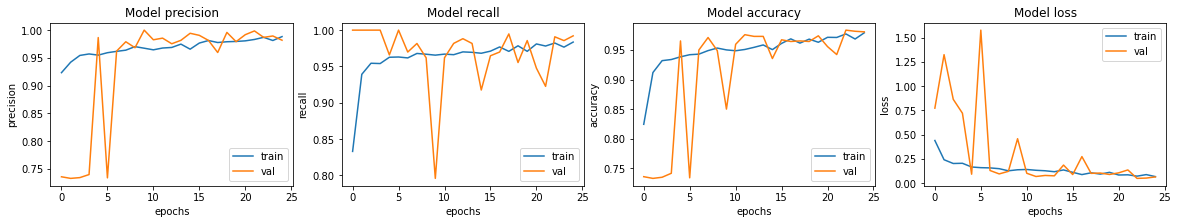

In [58]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [59]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 1.3664 - accuracy: 0.7869 - precision: 0.7495 - recall: 0.9897
Loss: 1.366421103477478,
Accuracy: 0.7868589758872986,
Precision: 0.7495145797729492,
Recall: 0.9897435903549194


In [ ]:
#dropout 비율만 변경

In [60]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [61]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [62]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.4),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [63]:
#데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [64]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [65]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 42s 133ms/step - loss: 0.5860 - accuracy: 0.7089 - precision: 0.9148 - recall: 0.6695 - val_loss: 0.5822 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2696 - accuracy: 0.8859 - precision: 0.9715 - recall: 0.8718 - val_loss: 1.4186 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.2572 - accuracy: 0.8967 - precision: 0.9707 - recall: 0.8897 - val_loss: 0.2246 - val_accuracy: 0.9087 - val_precision: 0.8895 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1894 - accuracy: 0.9236 - precision: 0.9742 - recall: 0.9215 - val_loss: 0.1369 - val_accuracy: 0.9442 - val_precision: 0.9403 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2099 - accura

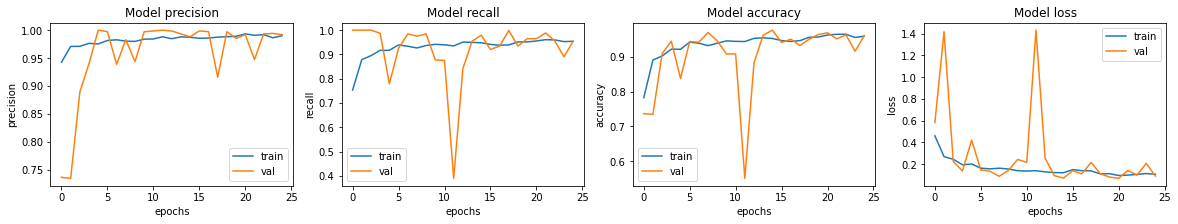

In [66]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [68]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.8815 - accuracy: 0.7740 - precision: 0.7475 - recall: 0.9641
Loss: 0.8815491795539856,
Accuracy: 0.7740384340286255,
Precision: 0.7475149035453796,
Recall: 0.964102566242218


### 2. 모델 훈련
1) optimizer 변경                                                                      
adam->rmsprop 사용

In [119]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [120]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [121]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [122]:
#데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [123]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [124]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )  

Epoch 1/25
261/261 [==============================] - 45s 140ms/step - loss: 0.5456 - accuracy: 0.7012 - precision: 0.9148 - recall: 0.6584 - val_loss: 0.6812 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 36s 138ms/step - loss: 0.2505 - accuracy: 0.9058 - precision: 0.9732 - recall: 0.8985 - val_loss: 1.4078 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 36s 137ms/step - loss: 0.2366 - accuracy: 0.9184 - precision: 0.9665 - recall: 0.9234 - val_loss: 0.2447 - val_accuracy: 0.9106 - val_precision: 0.9985 - val_recall: 0.8793
Epoch 4/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1657 - accuracy: 0.9393 - precision: 0.9801 - recall: 0.9378 - val_loss: 0.9685 - val_accuracy: 0.7452 - val_precision: 1.0000 - val_recall: 0.6522
Epoch 5/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1599 - accura

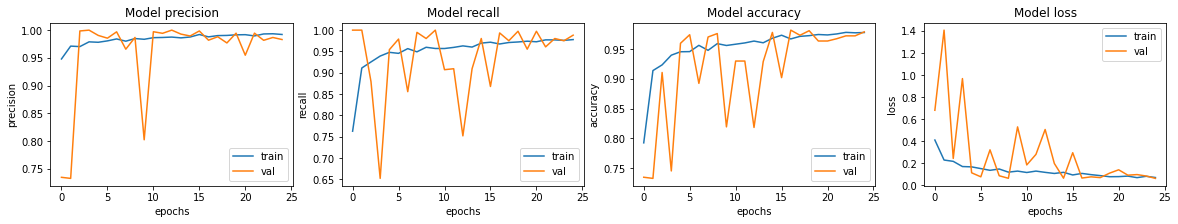

In [125]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [126]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 1.5208 - accuracy: 0.7516 - precision: 0.7156 - recall: 1.0000
Loss: 1.5207757949829102,
Accuracy: 0.7516025900840759,
Precision: 0.7155963182449341,
Recall: 1.0


### 3. Data imbalance 처리
1) imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정->처리 생략했을 때                                                                           
2)  recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과

In [145]:
# imblance 처리 안해줬을 때
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [146]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [147]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [148]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS,
    )

In [149]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
261/261 [==============================] - 41s 132ms/step - loss: 0.5826 - accuracy: 0.7118 - precision: 0.8812 - recall: 0.7053 - val_loss: 0.8187 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2432 - accuracy: 0.9094 - precision: 0.9429 - recall: 0.9350 - val_loss: 1.4377 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.2017 - accuracy: 0.9336 - precision: 0.9562 - recall: 0.9552 - val_loss: 0.1734 - val_accuracy: 0.9260 - val_precision: 0.9104 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2026 - accuracy: 0.9281 - precision: 0.9552 - recall: 0.9489 - val_loss: 0.1012 - val_accuracy: 0.9625 - val_precision: 0.9789 - val_recall: 0.9699
Epoch 5/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1851 - accura

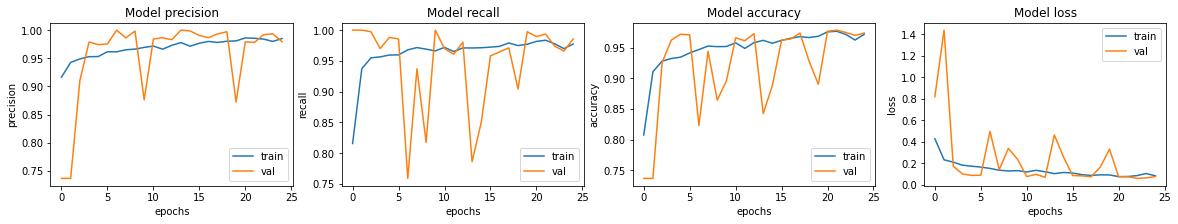

In [150]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [151]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.8311 - accuracy: 0.7917 - precision: 0.7510 - recall: 0.9974
Loss: 0.8310704231262207,
Accuracy: 0.7916666865348816,
Precision: 0.7509652376174927,
Recall: 0.9974358677864075


# 프로젝트 정리
1. Baseline 코드
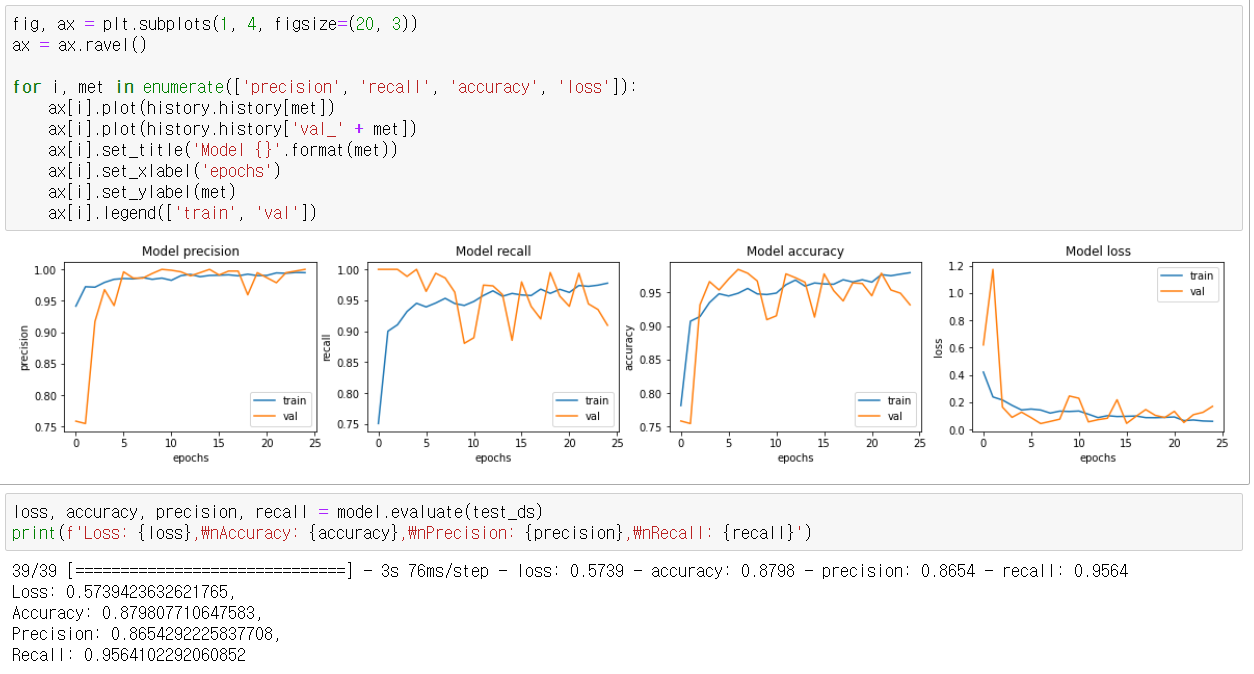
- Dropout+Batch Normalization 사용
- optimizer=adam
- Data imbalance 처리
2. 성능개선                                                                                 
1) CNN 모델링
- Dropout으로만 정규화 기법 사용 
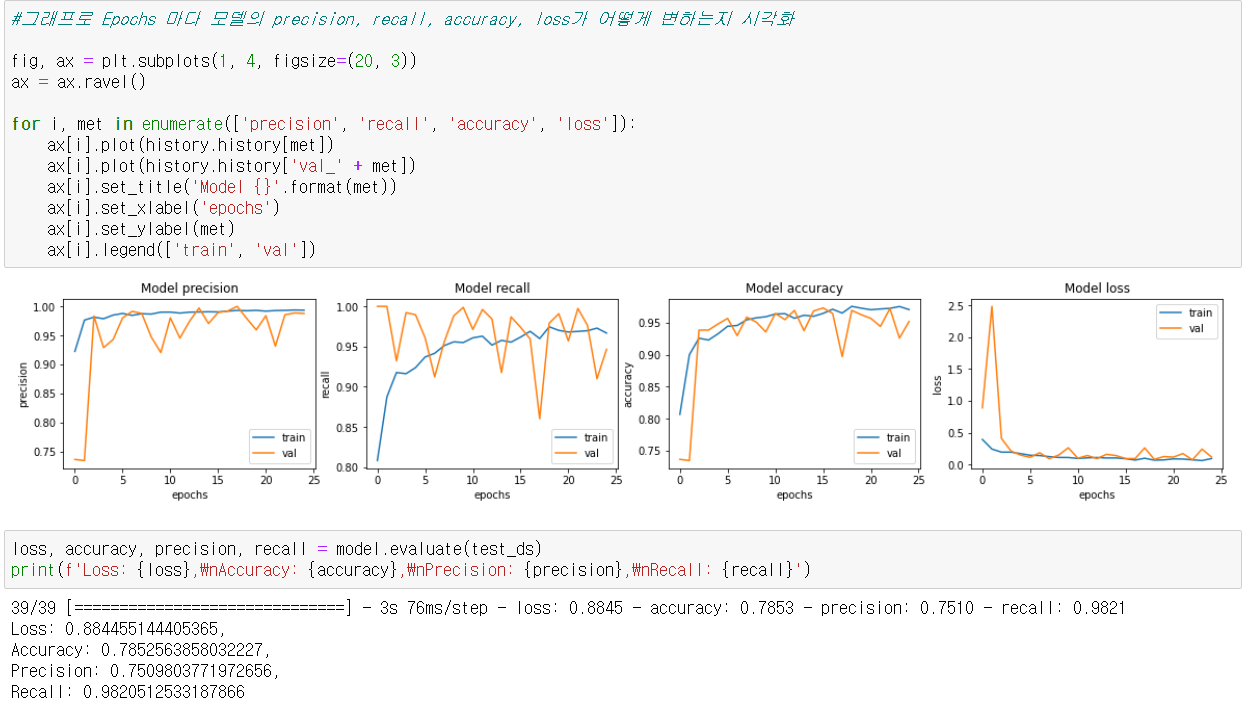
- Batch Normalization으로만 정규화 기법 사용
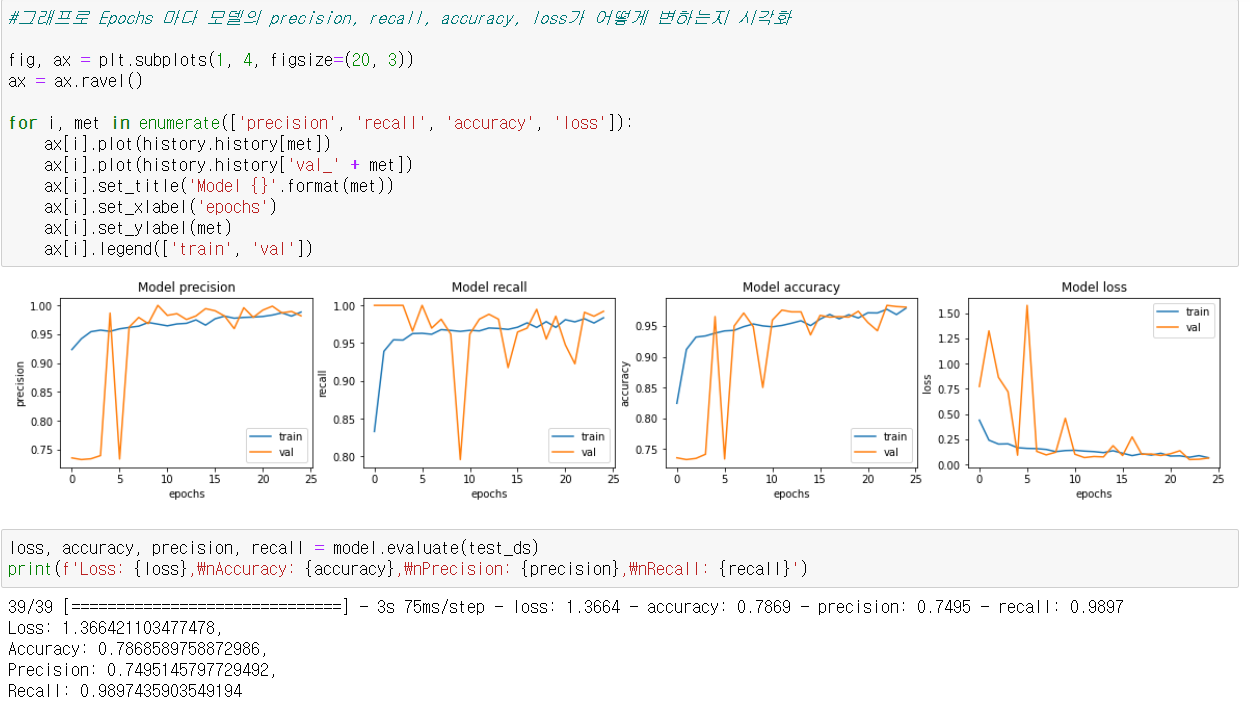
- Dropout 비율 변경
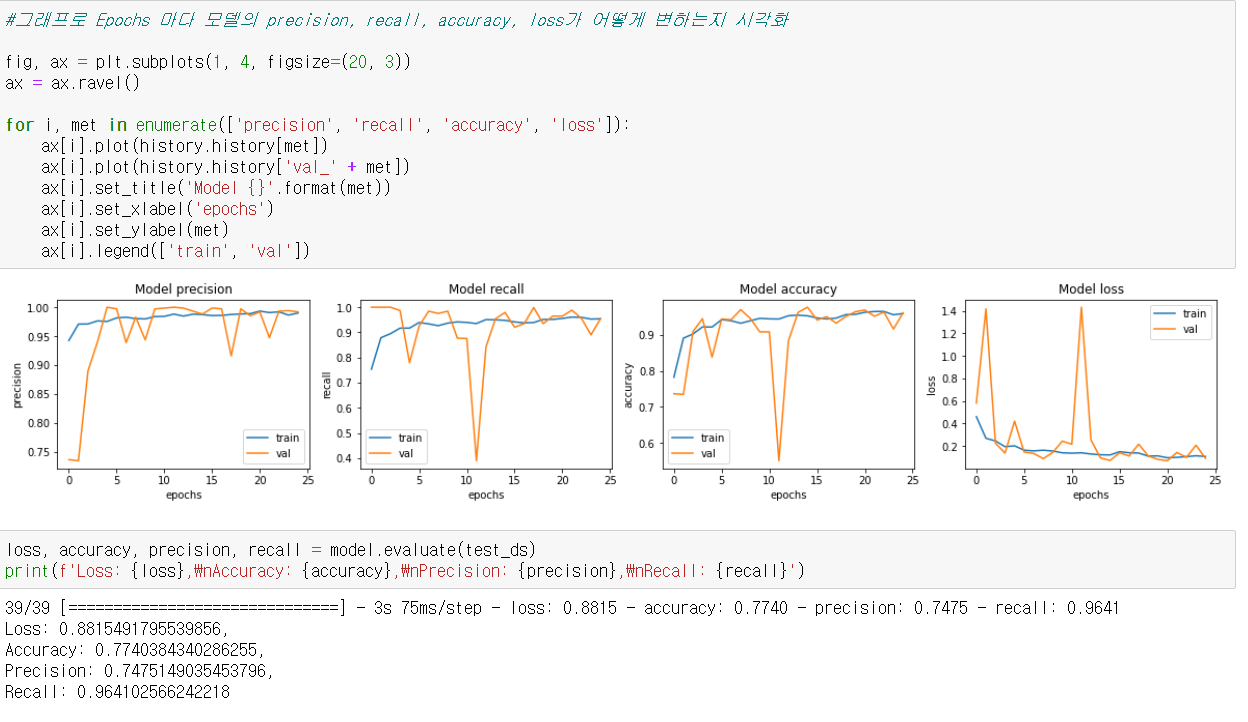
2) optimizer 변경                                                                      
- 'adam->rmsprop' 사용
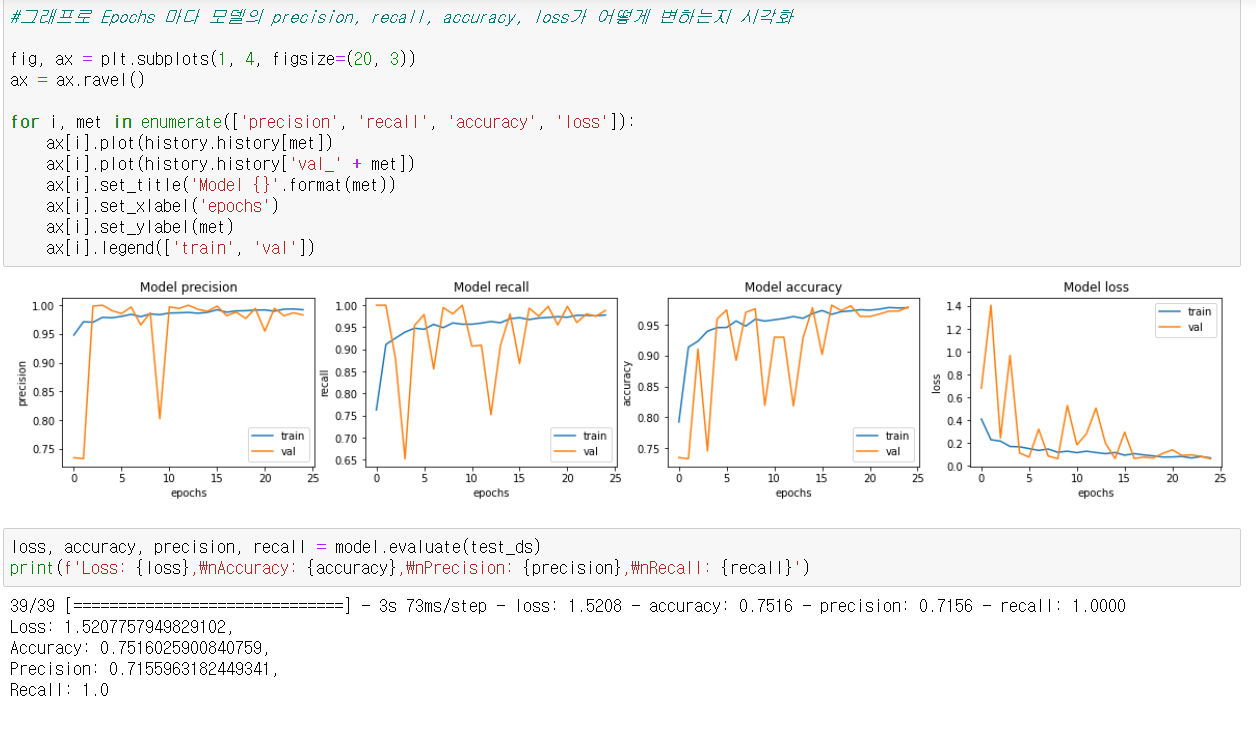
3) Data imbalance 처리
- imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정->처리 생략했을 때
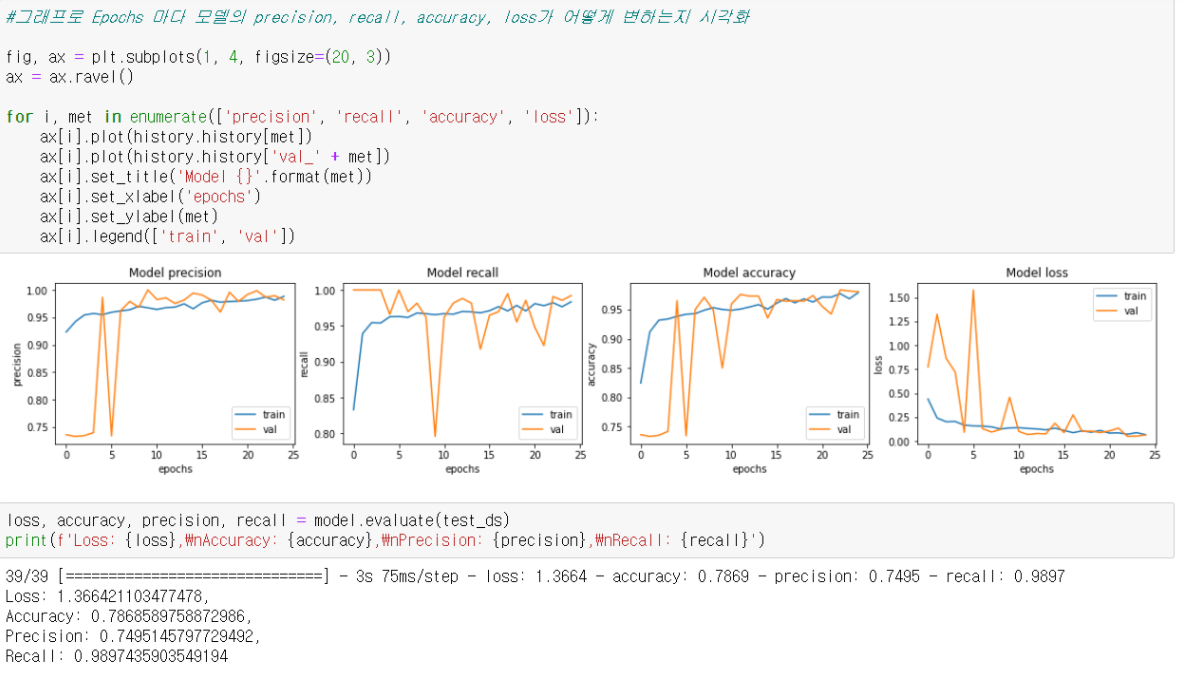

전부 recall 값이 크지만 accuracy와 precision 값이 작게 나오는 것을 볼 수 있다.
accuracy는 결과가 참값에 얼마나 가까운지를 나타내고, precision은 시스템이 얼마나 일관된 값을 출력하는지를 나타낸다. recall은 거의 1에 가까운 값이라 폐렴인 경우를 잘 추출해 냈다고 할 수 있는데, precision이랑 accuracy가 낮은걸로봐서 폐렴이 아닌경우에도 폐렴이라고 보는 경우가 많아 좋은 모델이라고 할 수 없다.                        
https://darkpgmr.tistory.com/162